# Prep Data for Finetuning: Dialogue Style

In [1]:
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split

TRANSCRIPTS_DIR = "../../transcripts_up_to_2024/"      # directory of raw JSONs of oral arguments
CASEBRIEF_DIR = "../../case_briefs_up_to_2025/"      # directory of raw JSONs of case briefs
OUT_DIR = "../finetuning_datasets/dialogue_style"

os.makedirs(OUT_DIR, exist_ok=True)

def save_jsonl(df, filename):
    df.to_json(filename, orient="records", lines=True)

def read_jsonl(filename):
    with open(filename, "r") as f:
        data = [json.loads(line) for line in f]
    return data

## Prep training samples for finetuning: `data_transcripts`

**Goal**: Process transcripts and casebriefs into a finetuning dataset that has the following format:

```
[
    [
        {'content': 'You are a legal expert trained to simulate Supreme Court oral arguments.
        
        FACTS_OF_THE_CASE:
        Jose Lopez, a Mexican national living in South Dakota, was convicted of aiding and abetting the possession of cocaine. The crime is a felony under South Dakota law, but only a misdemeanor under the federal Controlled Substances Act.
        The Immigration and Naturalization Service began proceedings to remove Lopez from the country. Lopez applied for a cancellation of his removal, citing the Immigration and Naturalization Act (INA). The INA allows an alien to avoid removal if he meets certain qualifications and has no prior "aggravated felony" convictions. Lopez argued that he was eligible for cancellation of his removal because his drug offense was only a misdemeanor under federal law.
        An Immigration Judge denied Lopez\'s request for cancellation, and the Board of Immigration Appeals affirmed, on the grounds that Lopez had committed an aggravated felony. Lopez then sued the Attorney General and brought his case to the Court of Appeals for the Eighth Circuit. The Circuit Court affirmed the lower courts, ruling that a crime is an aggravated felony under the INA if it is a felony under either federal or state law.
        
        LEGAL_QUESTION:
        Does a drug crime constitute an "aggravated felony" under the Immigration and Naturalization Act if the crime is a felony under state law but only a misdemeanor under federal law?',
        'role': 'system'},
        {'content': "We'll hear argument first this morning in Lopez versus Gonzales and Toledo-Flores versus United States. Mr. Long."
        'role': 'justice_john_g_roberts_jr'},
        {'content': 'Mr. Chief Justice, and may it please the Court: A drug-trafficking crime is defined in 18 U.S. Code Section 924(c) as any felony punishable under the Controlled Substances Act or two other Federal statutes...',
        'role': 'advocate'},
        {'content': 'Well, do you agree that if there were a State conviction for an offense that would have been punishable under the Federal law, their both being felonies, that enhancement can apply, in that instance, and that that does meet the definition?',
        'role': 'justice_anthony_m_kennedy'},
    ... <remaining_turns_from_transcript_1>],
    [
        {'content': 'You are a legal expert trained to simulate Supreme Court oral arguments.
        
        FACTS_OF_THE_CASE:
        When Joe Sullivan was 13 years old, he was convicted of sexual battery by a Florida state court and sentenced to life in prison without parole. On appeal to the District Court of Appeal of Florida, Mr. Sullivan argued that his sentence was cruel and unusual and thus violated both the Eighth and Fourteenth Amendments. The court of appeals affirmed Mr. Sullivan\'s sentence without comment.
        
        LEGAL_QUESTION:
        Does the imposition of a life sentence without parole on a 13 year old convicted of a non-homicidal offense violate the Eighth and Fourteenth Amendments\' prohibition of "cruel and unusual punishment?"',
        'role': 'system'},
        {'content': 'We will hear argument next in Case 08-7621, Sullivan v. Florida. Mr. Stevenson.',
        'role': 'justice_john_g_roberts_jr'},
        {'content': 'Mr. Chief Justice, and may it please the Court: Joe Sullivan was 13 years of age when he was arrested with two older boys, one 15 and one 17, charged with sexual assault, ultimately convicted, and sentenced to life without parole. Joe is one of only two children this age who have ever been sentenced to life without parole for a non-homicide, and no child has received this sentence for non-homicide in the last 18 years.',
        'role': 'advocate'},
        {'content': "Mr. Stevenson, there's a serious question before we get to the particulars of this case. Justice Kennedy suggested it in the last argument. This -- the time ran out for postconviction relief in 1993, and this petition is brought in 2007. There's a 2-year statute of limitations. Florida said there's a procedural bar; we don't get to the merits of this case.",
        'role': 'justice_ruth_bader_ginsburg'},
    ... <remaining_turns_from_transcript_2>],
...]
```



<!-- ```
[
    {'transcript_id': '2006.05-547',
    'messages': [
        {'role': 'system',
        'content': 'You are a legal expert trained to simulate Supreme Court oral arguments.
        
        FACTS_OF_THE_CASE:
        Jose Lopez, a Mexican national living in South Dakota, was convicted of aiding and abetting the possession of cocaine. The crime is a felony under South Dakota law, but only a misdemeanor under the federal Controlled Substances Act.
        The Immigration and Naturalization Service began proceedings to remove Lopez from the country. Lopez applied for a cancellation of his removal, citing the Immigration and Naturalization Act (INA). The INA allows an alien to avoid removal if he meets certain qualifications and has no prior "aggravated felony" convictions. Lopez argued that he was eligible for cancellation of his removal because his drug offense was only a misdemeanor under federal law.
        An Immigration Judge denied Lopez\'s request for cancellation, and the Board of Immigration Appeals affirmed, on the grounds that Lopez had committed an aggravated felony. Lopez then sued the Attorney General and brought his case to the Court of Appeals for the Eighth Circuit. The Circuit Court affirmed the lower courts, ruling that a crime is an aggravated felony under the INA if it is a felony under either federal or state law.
        
        LEGAL_QUESTION:
        Does a drug crime constitute an "aggravated felony" under the Immigration and Naturalization Act if the crime is a felony under state law but only a misdemeanor under federal law?'},
        {'role': 'justice_john_g_roberts_jr',
        'content': "We'll hear argument first this morning in Lopez versus Gonzales and Toledo-Flores versus United States. Mr. Long."},
        {'role': 'advocate',
        'content': 'Mr. Chief Justice, and may it please the Court: A drug-trafficking crime is defined in 18 U.S. Code Section 924(c) as any felony punishable under the Controlled Substances Act or two other Federal statutes...'},
        {'role': 'justice_anthony_m_kennedy',
        'content': 'Well, do you agree that if there were a State conviction for an offense that would have been punishable under the Federal law, their both being felonies, that enhancement can apply, in that instance, and that that does meet the definition?'},
        ...]
    },
    {'transcript_id': '2009.08-7621',
    'messages': [
        {'role': 'system',
        'content': 'You are a legal expert trained to simulate Supreme Court oral arguments.
        
        FACTS_OF_THE_CASE:
        When Joe Sullivan was 13 years old, he was convicted of sexual battery by a Florida state court and sentenced to life in prison without parole. On appeal to the District Court of Appeal of Florida, Mr. Sullivan argued that his sentence was cruel and unusual and thus violated both the Eighth and Fourteenth Amendments. The court of appeals affirmed Mr. Sullivan\'s sentence without comment.
        
        LEGAL_QUESTION:
        Does the imposition of a life sentence without parole on a 13 year old convicted of a non-homicidal offense violate the Eighth and Fourteenth Amendments\' prohibition of "cruel and unusual punishment?"'},
        {'role': 'justice_john_g_roberts_jr',
        'content': 'We will hear argument next in Case 08-7621, Sullivan v. Florida. Mr. Stevenson.'},
        {'role': 'advocate',
        'content': 'Mr. Chief Justice, and may it please the Court: Joe Sullivan was 13 years of age when he was arrested with two older boys, one 15 and one 17, charged with sexual assault, ultimately convicted, and sentenced to life without parole. Joe is one of only two children this age who have ever been sentenced to life without parole for a non-homicide, and no child has received this sentence for non-homicide in the last 18 years.'},
        {'role': 'justice_ruth_bader_ginsburg',
        'content': "Mr. Stevenson, there's a serious question before we get to the particulars of this case. Justice Kennedy suggested it in the last argument. This -- the time ran out for postconviction relief in 1993, and this petition is brought in 2007. There's a 2-year statute of limitations. Florida said there's a procedural bar; we don't get to the merits of this case."},
        ... ]
    }
]
``` -->

<!-- ```
training_samples = [
    {
        "transcript_id": "2022.21-376-t01",
        "chunk_id": 0,
        "content": [
            {"role": "advocate", "content": "Advocate gives their opening statement"},
            {"role": "justice_sonia_sotomayor", "content": "Sotomayor asks a question based on advocate's opening statement."},
            {"role": "advocate", "content": "Advocate says something in response to Sotomayor"},
            {"role": "justice_samuel_a_alito_jr", "content": "Something Justice Alito said in transcript."},
        ]
    },
...
]
``` -->


In [2]:
import re
def clean_text(text):
    if text:
        # Remove HTML tags
        text = re.sub(r'<[^>]+>', '', text)
        # Replace unicode characters
        text = text.replace("\u201c", "\"").replace("\u201d", "\"").replace("\u2018", "'").replace("\u2019", "'")
        return text.strip()
    else:
        return 'UNKNOWN'

def get_facts_and_question(transcript_id, dir=CASEBRIEF_DIR):
    case_brief_file_path = os.path.join(dir, transcript_id + ".json")
    with open(case_brief_file_path, 'r') as json_file:
        case_brief_json = json.load(json_file)
        facts = clean_text(case_brief_json['facts_of_the_case'])
        question = clean_text(case_brief_json['question'])
        return facts, question

def get_system_prompt(transcript_id):
    facts, question = get_facts_and_question(transcript_id)
    return f"You are a legal expert trained to simulate Supreme Court oral arguments.\n\nFACTS_OF_THE_CASE:\n{facts}\n\nLEGAL_QUESTION:\n{question}"


def get_formatted_text_of_turn(turn, advocate):
    '''
    Return all text within a turn as a dict denoting speaker role, and text.

    @param turn -- JSON representing a single speaker turn
    @return -- Dict with keys "role", "content"
    '''
    if not turn["speaker"]:  # skip turns that have no speaker like "Laughter"
        return None

    if not turn["speaker"]["roles"]:
        role = "attorney"
    elif ('2' in turn["speaker"]["roles"] and turn["speaker"]["roles"]['2']["type"] == "scotus_justice") or \
         turn["speaker"]["roles"][0]["type"] == "scotus_justice":
        role = "scotus_justice"

    if role == "scotus_justice":
        identifier = f'justice_{turn["speaker"]["identifier"]}'
    else:
        identifier = advocate

    text = " ".join([block["text"] for block in turn["text_blocks"]])

    return {
        "role": identifier,
        "content": text
    }

def get_transcript_data(json_file_name):
    '''
    @param json_file_name -- Name of the oral argument JSON file
    @return -- List of dicts with keys "role", "content" representing each speaker turn in the transcript
    '''

    transcript_file_path = os.path.join(TRANSCRIPTS_DIR, json_file_name)
    with open(transcript_file_path, 'r') as json_file:
        transcript_json = json.load(json_file)

    formatted_turns = []
    for section in [0, 1]:
        advocate = 'respondent' if section else 'petitioner' 
        section_turns = transcript_json["transcript"]["sections"][section]["turns"]
        section_turns = [get_formatted_text_of_turn(turn, advocate) for turn in section_turns]
        section_turns = [turn for turn in section_turns if turn]  # remove None values
        formatted_turns.extend(section_turns)

    return formatted_turns

# Load all transcripts
data_transcripts = []
cases_dir = os.fsencode(TRANSCRIPTS_DIR)
for json_file_name in os.listdir(TRANSCRIPTS_DIR):
    if json_file_name.endswith('.json'):
        # Extract the transcript_id
        transcript_id = json_file_name[:-9]
        try:
            # Load the corresponding case brief and extract the facts of the case and the legal question
            system_prompt = get_system_prompt(transcript_id)
            messages = [
                {
                    "role": "system",
                    "content": system_prompt
                }
            ]
        except Exception:
            print(f"Could not get facts and question from case brief: Skipping {transcript_id}")
            continue
        # Load the transcript and extract the messages
        messages.extend(get_transcript_data(json_file_name))
        data_transcripts.append({
            "transcript_id": transcript_id,
            "messages": messages
        })

Could not get facts and question from case brief: Skipping 2008.105_orig
Could not get facts and question from case brief: Skipping 2007.134_orig
Could not get facts and question from case brief: Skipping 2009.138_orig
Could not get facts and question from case brief: Skipping 2009.132_orig
Could not get facts and question from case brief: Skipping 1992.91_522
Could not get facts and question from case brief: Skipping 2003.129_orig
Could not get facts and question from case brief: Skipping 2019.18-1587
Could not get facts and question from case brief: Skipping 2010.137_orig
Could not get facts and question from case brief: Skipping 2004.128_orig
Could not get facts and question from case brief: Skipping 2004.105_orig
Could not get facts and question from case brief: Skipping 2016.15-1498
Could not get facts and question from case brief: Skipping 2016.15-1204


## Apply chat template - Sanity test + get token counts

Sample input json:

```
[
    {
        'content': 'You are a legal expert trained to simulate Supreme Court oral arguments.

        FACTS_OF_THE_CASE:
        Jose Lopez, a Mexican national living in South Dakota...

        LEGAL_QUESTION:
        Does a drug crime constitute an "aggravated felony" under the Immigration and Naturalization Act if the crime is a felony under state law but only a misdemeanor under federal law?',
        'role': 'system'
    },
    {
        'content': "We'll hear argument first this morning in Lopez versus Gonzales and Toledo-Flores versus United States. Mr. Long."
        'role': 'justice_john_g_roberts_jr'
    },
    {
        'content': 'Mr. Chief Justice, and may it please the Court: A drug-trafficking crime is defined in 18 U.S. Code Section 924(c) as any felony punishable under the Controlled Substances Act or two other Federal statutes...',
        'role': 'advocate'
    },
    {
        'content': 'Well, do you agree that if there were a State conviction for an offense that would have been punishable under the Federal law, their both being felonies, that enhancement can apply, in that instance, and that that does meet the definition?',
        'role': 'justice_anthony_m_kennedy'},
]

```
This should map to something like the following after applying chat template (added new-lines before and after special tokens for readability)

```
<|begin_of_text|>
<|start_header_id|>
system
<|end_header_id|>

You are a legal expert trained to simulate Supreme Court oral arguments.

FACTS_OF_THE_CASE:
Jose Lopez, a Mexican national living in South Dakota...

LEGAL_QUESTION:
Does a drug crime constitute an "aggravated felony" under the Immigration and Naturalization Act if the crime is a felony under state law but only a misdemeanor under federal law?
<|eot_id|>
<|start_header_id|>
justice_john_g_roberts_jr
<|end_header_id|>

We'll hear argument first this morning in Lopez versus Gonzales and Toledo-Flores versus United States. Mr. Long.
<|eot_id|>
<|start_header_id|>
advocate
<|end_header_id|>

Mr. Chief Justice, and may it please the Court: A drug-trafficking crime is defined in 18 U.S. Code Section 924(c) as any felony punishable under the Controlled Substances Act or two other Federal statutes...
<|eot_id|>
<|start_header_id|>
justice_anthony_m_kennedy
<|end_header_id|>

Well, do you agree that if there were a State conviction for an offense that would have been punishable under the Federal law, their both being felonies, that enhancement can apply, in that instance, and that that does meet the definition?
<|eot_id|>

```


<!-- Sample input json:

```
chat = [
    {"role": "advocate", "content": "Advocate gives their opening statement"},
    {"role": "justice_sonia_sotomayor", "content": "Sotomayor asks a question based on advocate's opening statement."},
    {"role": "advocate", "content": "Advocate says something in response to Sotomayor"},
    {"role": "justice_samuel_a_alito_jr", "content": "Something Justice Alito said in transcript."},
]
```

This should map to something like the following after applying chat template (added new-lines for readability)
```
<|begin_of_text|>
<|start_header_id|>
advocate
<|end_header_id|>
Advocate gives their opening statement
<|eot_id|>
<|start_header_id|>
justice_sonia_sotomayor
<|end_header_id|>
Sotomayor asks a question based on advocate's opening statement.
<|eot_id|>
<|start_header_id|>
advocate
<|end_header_id|>
Advocate says something in response to Sotomayor
<|eot_id|>
<|start_header_id|>
justice_samuel_a_alito_jr
<|end_header_id|>
Something Justice Alito said in transcript.
<|eot_id|>
``` -->

In [3]:
## Load the tokenizer from Huggingface (for LOCAL TESTING)
from transformers import AutoTokenizer

# MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"
MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [4]:
# ## Load tokenizer in exactly the same way as we do in the finetuning script (for DELLA TESTING)
# from unsloth import FastLanguageModel

# MODEL_NAME = "Meta-Llama-3.1-8B-Instruct-bnb-4bit"

# model_name = f"/scratch/gpfs/nnadeem/transformer_cache/{MODEL_NAME}/"
# max_seq_length = 65536
# dtype = None
# load_in_4bit = True
# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = model_name,
#     max_seq_length = max_seq_length,
#     dtype = dtype,
#     load_in_4bit = load_in_4bit,
# )

In [5]:
from datasets import Dataset

# Run cells in previous section to generate data_transcripts
dialogues = [transcript["messages"] for transcript in data_transcripts]
ids = [transcript["transcript_id"] for transcript in data_transcripts]
dataset = Dataset.from_dict({
    "chat": dialogues,
    "transcript_id": ids
})

#### Apply Original Chat Template

Contains the following string in the system prompt by default, which seems like a bug:
`"Cutting Knowledge Date: December 2023 \nToday Date: 26 Jul 2024"`


In [6]:
# Uncomment to see and apply original chat template
# print(tokenizer.chat_template)
# dataset = dataset.map(lambda x: {"formatted_chat": tokenizer.apply_chat_template(x["chat"], tokenize=False, add_generation_prompt=False)})
# print(dataset['formatted_chat'][0])

#### Set Custom Chat Template

In [7]:
## Set custom chat template
def set_chat_template():
    return """<|begin_of_text|>{%- for message in messages %}<|start_header_id|>{{ message['role'] }}<|end_header_id|>\n\n{{ message['content'] }}<|eot_id|>{%- endfor %}"""
tokenizer.chat_template = set_chat_template()

In [8]:
dataset = dataset.map(lambda x: {"formatted_chat": tokenizer.apply_chat_template(x["chat"], tokenize=False, add_generation_prompt=False)})
print(dataset['formatted_chat'][1])

Map:   0%|          | 0/2427 [00:00<?, ? examples/s]

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a legal expert trained to simulate Supreme Court oral arguments.

FACTS_OF_THE_CASE:
Jose Lopez, a Mexican national living in South Dakota, was convicted of aiding and abetting the possession of cocaine. The crime is a felony under South Dakota law, but only a misdemeanor under the federal Controlled Substances Act.
The Immigration and Naturalization Service began proceedings to remove Lopez from the country. Lopez applied for a cancellation of his removal, citing the Immigration and Naturalization Act (INA). The INA allows an alien to avoid removal if he meets certain qualifications and has no prior "aggravated felony" convictions. Lopez argued that he was eligible for cancellation of his removal because his drug offense was only a misdemeanor under federal law.
An Immigration Judge denied Lopez's request for cancellation, and the Board of Immigration Appeals affirmed, on the grounds that Lopez had committed an aggra

**Note**: Rather than using the custom `set_chat_template()` function defined above, we could alternatively modify the original chat template function of the model (modified to not include a system prompt with today's data always by default). Right now I just used a simpler template for clarity.

For reference, original chat template for `unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit` is:
```
{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- set date_string = "26 Jul 2024" %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0][\'role\'] == \'system\' %}\n    {%- set system_message = messages[0][\'content\']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = "" %}\n{%- endif %}\n\n{#- System message + builtin tools #}\n{{- "<|start_header_id|>system<|end_header_id|>\\n\\n" }}\n{%- if builtin_tools is defined or tools is not none %}\n    {{- "Environment: ipython\\n" }}\n{%- endif %}\n{%- if builtin_tools is defined %}\n    {{- "Tools: " + builtin_tools | reject(\'equalto\', \'code_interpreter\') | join(", ") + "\\n\\n"}}\n{%- endif %}\n{{- "Cutting Knowledge Date: December 2023\\n" }}\n{{- "Today Date: " + date_string + "\\n\\n" }}\n{%- if tools is not none and not tools_in_user_message %}\n    {{- "You have access to the following functions. To call a function, please respond with JSON for a function call." }}\n    {{- \'Respond in the format {"name": function name, "parameters": dictionary of argument name and its value}.\' }}\n    {{- "Do not use variables.\\n\\n" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- "\\n\\n" }}\n    {%- endfor %}\n{%- endif %}\n{{- system_message }}\n{{- "<|eot_id|>" }}\n\n{#- Custom tools are passed in a user message with some extra guidance #}\n{%- if tools_in_user_message and not tools is none %}\n    {#- Extract the first user message so we can plug it in here #}\n    {%- if messages | length != 0 %}\n        {%- set first_user_message = messages[0][\'content\']|trim %}\n        {%- set messages = messages[1:] %}\n    {%- else %}\n        {{- raise_exception("Cannot put tools in the first user message when there\'s no first user message!") }}\n{%- endif %}\n    {{- \'<|start_header_id|>user<|end_header_id|>\\n\\n\' -}}\n    {{- "Given the following functions, please respond with a JSON for a function call " }}\n    {{- "with its proper arguments that best answers the given prompt.\\n\\n" }}\n    {{- \'Respond in the format {"name": function name, "parameters": dictionary of argument name and its value}.\' }}\n    {{- "Do not use variables.\\n\\n" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- "\\n\\n" }}\n    {%- endfor %}\n    {{- first_user_message + "<|eot_id|>"}}\n{%- endif %}\n\n{%- for message in messages %}\n    {%- if not (message.role == \'ipython\' or message.role == \'tool\' or \'tool_calls\' in message) %}\n        {{- \'<|start_header_id|>\' + message[\'role\'] + \'<|end_header_id|>\\n\\n\'+ message[\'content\'] | trim + \'<|eot_id|>\' }}\n    {%- elif \'tool_calls\' in message %}\n        {%- if not message.tool_calls|length == 1 %}\n            {{- raise_exception("This model only supports single tool-calls at once!") }}\n        {%- endif %}\n        {%- set tool_call = message.tool_calls[0].function %}\n        {%- if builtin_tools is defined and tool_call.name in builtin_tools %}\n            {{- \'<|start_header_id|>assistant<|end_header_id|>\\n\\n\' -}}\n            {{- "<|python_tag|>" + tool_call.name + ".call(" }}\n            {%- for arg_name, arg_val in tool_call.arguments | items %}\n                {{- arg_name + \'="\' + arg_val + \'"\' }}\n                {%- if not loop.last %}\n                    {{- ", " }}\n                {%- endif %}\n                {%- endfor %}\n            {{- ")" }}\n        {%- else  %}\n            {{- \'<|start_header_id|>assistant<|end_header_id|>\\n\\n\' -}}\n            {{- \'{"name": "\' + tool_call.name + \'", \' }}\n            {{- \'"parameters": \' }}\n            {{- tool_call.arguments | tojson }}\n            {{- "}" }}\n        {%- endif %}\n        {%- if builtin_tools is defined %}\n            {#- This means we\'re in ipython mode #}\n            {{- "<|eom_id|>" }}\n        {%- else %}\n            {{- "<|eot_id|>" }}\n        {%- endif %}\n    {%- elif message.role == "tool" or message.role == "ipython" %}\n        {{- "<|start_header_id|>ipython<|end_header_id|>\\n\\n" }}\n        {%- if message.content is mapping or message.content is iterable %}\n            {{- message.content | tojson }}\n        {%- else %}\n            {{- message.content }}\n        {%- endif %}\n        {{- "<|eot_id|>" }}\n    {%- endif %}\n{%- endfor %}\n{%- if add_generation_prompt %}\n    {{- \'<|start_header_id|>assistant<|end_header_id|>\\n\\n\' }}\n{%- endif %}\n
```

### Get token count distribution

In [9]:
def count_tokens(example):
    tokens = tokenizer(example["formatted_chat"], return_length=True, add_special_tokens=False)
    return {"num_tokens": tokens["length"][0]}

# Add token count to each example
dataset = dataset.map(count_tokens)

Map:   0%|          | 0/2427 [00:00<?, ? examples/s]

In [11]:
total_tokens = sum(dataset["num_tokens"])
average_tokens = total_tokens / len(dataset)
max = max(dataset["num_tokens"])

print(f"Total tokens: {total_tokens}")
print(f"Max tokens: {max}")
print(f"Average tokens per example: {average_tokens:.2f}")

Total tokens: 27330860
Max tokens: 39946
Average tokens per example: 11261.17


In [12]:
import matplotlib.pyplot as plt

def plot_summary_stats(dataset):
    token_counts = dataset["num_tokens"]
    plt.figure(figsize=(10, 6))
    plt.hist(token_counts, bins=50, edgecolor="black")
    plt.title("Token Count Distribution Across Samples")
    plt.xlabel("Number of Tokens")
    plt.ylabel("Number of Samples")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

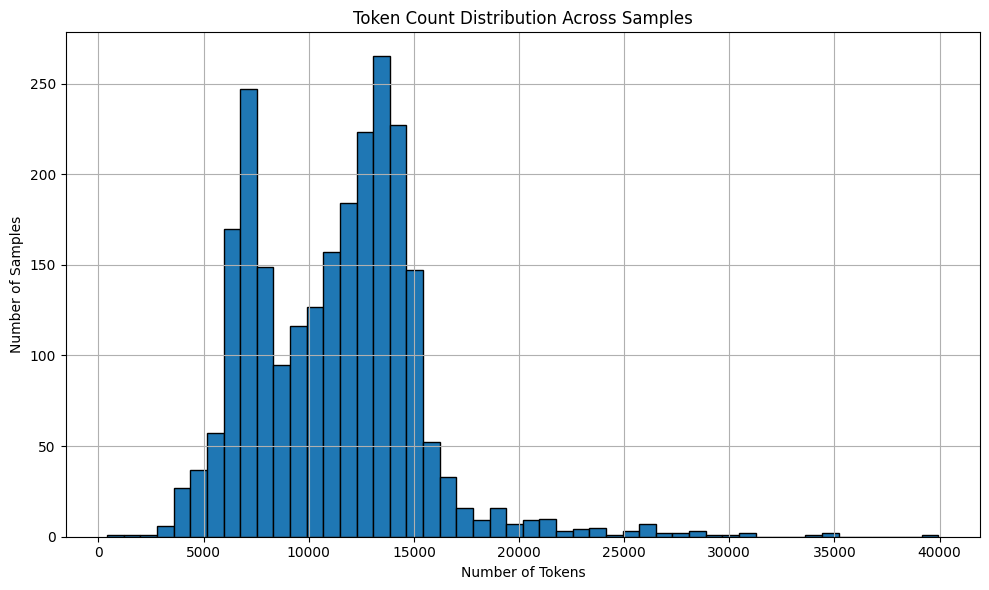

In [13]:
plot_summary_stats(dataset)


### Filter dataset to token counts < 15k

In [14]:
print(f"Original dataset len: {len(dataset)}")

Original dataset len: 2427


In [15]:
# filter dataset to samples below 15k tokens
dataset = dataset.filter(lambda x: x["num_tokens"] <= 15000)

Filter:   0%|          | 0/2427 [00:00<?, ? examples/s]

In [16]:
print(f"Filtered dataset len: {len(dataset)}")

Filtered dataset len: 2175


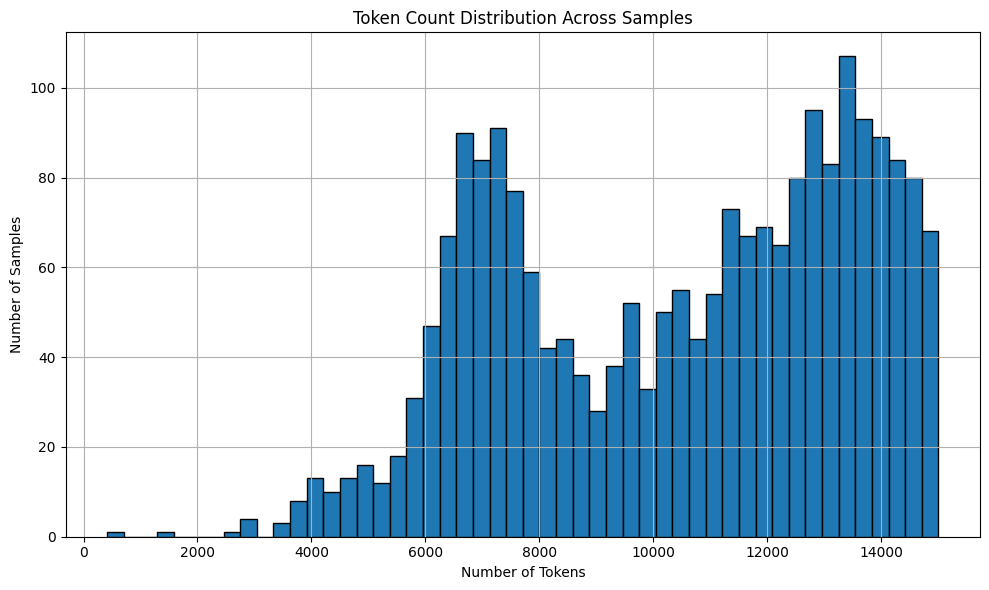

In [17]:
plot_summary_stats(dataset)

### Train Test Split

In [20]:
RANDOM_SEED = 42

df = dataset.to_pandas()
df.rename(columns={"chat": "messages"}, inplace=True)

train_ratio = 0.80
val_ratio = 0.10
test_ratio = 0.10

# 0. get unique transcript_ids
transcript_ids = df['transcript_id'].unique()

# 1. split into train (80%) and eval (20%)
train_ids, eval_ids = train_test_split(
    transcript_ids, 
    test_size=(val_ratio + test_ratio), 
    random_state=RANDOM_SEED
)

# 2. split eval into validation (10%) and test (10%)
val_ids, test_ids = train_test_split(
    eval_ids, 
    test_size=(test_ratio / (val_ratio + test_ratio)), 
    random_state=RANDOM_SEED
)

train_data = df[df['transcript_id'].isin(train_ids)]
val_data = df[df['transcript_id'].isin(val_ids)]
test_data = df[df['transcript_id'].isin(test_ids)]

# 3. save splits
save_jsonl(train_data, f"{OUT_DIR}/train.jsonl")
save_jsonl(val_data, f"{OUT_DIR}/val.jsonl")
save_jsonl(test_data, f"{OUT_DIR}/test.jsonl")

print(f"Dataset split complete:\nTrain: {len(train_data)}\nValidation: {len(val_data)}\nTest: {len(test_data)}")
print(f"\nTRANSCRIPT ID counts:\nTotal: {len(transcript_ids)}\nTrain: {len(train_ids)}\nValidation: {len(val_ids)}\nTest: {len(test_ids)}")

Dataset split complete:
Train: 1739
Validation: 217
Test: 219

TRANSCRIPT ID counts:
Total: 2158
Train: 1726
Validation: 216
Test: 216


#### Create small test subsample for quick testing

In [21]:
RANDOM_SEED = 42
SAMPLE_SIZE = 100

input_file = f"{OUT_DIR}/test.jsonl"
df = pd.read_json(input_file, lines=True)

test_sample = df.sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED)
save_jsonl(test_sample, f"{OUT_DIR}/test_{SAMPLE_SIZE}.jsonl")